In [43]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import pipeline

In [45]:
df_movies = pd.read_csv('/content/drive/My Drive/ColabNotebooks/rotten_tomatoes_movies.csv')
df_critic_review = pd.read_csv('/content/drive/My Drive/ColabNotebooks/rotten_tomatoes_critic_reviews.csv')

In [46]:
df_movies_merged = df_critic_review.merge(df_movies, how='inner', on=['rotten_tomatoes_link'])
df_movies_merged = df_movies_merged[['rotten_tomatoes_link', 'movie_title', 'review_content', 'review_type', 'tomatometer_status']]
df_movies_merged.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,With a top-notch cast and dazzling special eff...,Fresh,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Whether audiences will get behind The Lightnin...,Fresh,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,What's really lacking in The Lightning Thief i...,Rotten,Rotten


In [47]:
df_movies_merged.isnull().sum()

rotten_tomatoes_link        0
movie_title                 0
review_content          65778
review_type                 0
tomatometer_status       1466
dtype: int64

In [48]:
df_movies_merged = df_movies_merged.dropna(subset=['review_content'])
df_movies_merged = df_movies_merged.dropna(subset=['tomatometer_status'])
df_movies_merged.isnull().sum()

rotten_tomatoes_link    0
movie_title             0
review_content          0
review_type             0
tomatometer_status      0
dtype: int64

In [49]:
df_sub = df_movies_merged[0:10000]
review_type = pd.DataFrame(df_sub['review_type'].replace(['Rotten', 'Fresh'],[0,1]))
df_ft_critics = pd.concat([df_sub[['review_content']],review_type], axis=1).dropna()
df_ft_critics.head()

,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,1
1,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,With a top-notch cast and dazzling special eff...,1
3,Whether audiences will get behind The Lightnin...,1
4,What's really lacking in The Lightning Thief i...,0


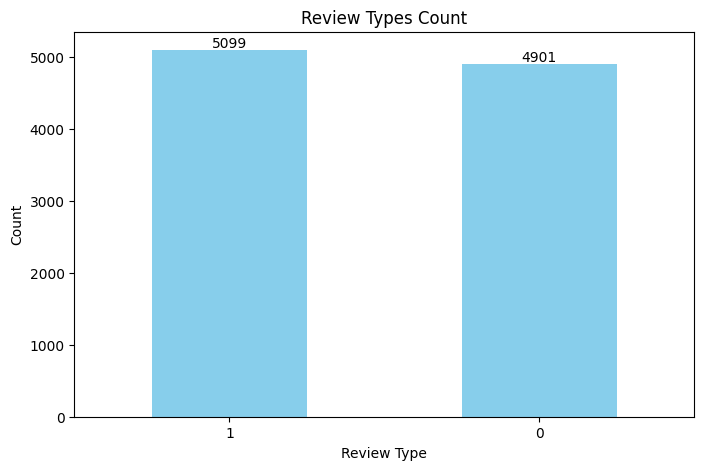

In [50]:
ax = df_ft_critics['review_type'].value_counts().plot(kind='bar', figsize=(8,5), color='skyblue')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=10, rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.title('Review Types Count')
plt.show()

In [51]:
X = df_ft_critics['review_content']
y = df_ft_critics['review_type']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [54]:
y_pred_sentiment = [sent_pipeline(review)[0]['label'] for review in X_test]
y_pred = np.where(np.array(y_pred_sentiment) == 'POSITIVE', 1, 0)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       989
           1       0.81      0.86      0.84      1011

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



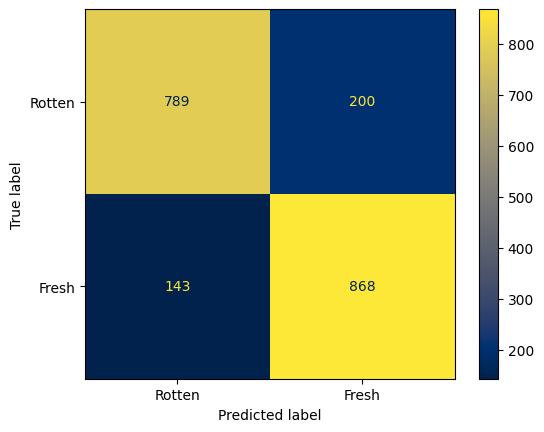

In [56]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Rotten', 'Fresh'])
disp.plot(cmap='cividis')
plt.show()

In [57]:
def predict_sentiment(movie_name):
  df_movie = df_movies_merged[df_movies_merged["movie_title"].str.contains(movie_name, case=False, na=False)]
  review_type = pd.DataFrame(df_movie['review_type'].replace(['Rotten', 'Fresh'],[0,1]))
  df_movie_rev = pd.concat([df_movie[['review_content']],review_type], axis=1).dropna()

  df_movie_rev['predicted_sentiment'] = df_movie_rev['review_content'].apply(lambda x: sent_pipeline(x)[0]['label'])
  df_movie_rev['predicted_label'] = df_movie_rev['predicted_sentiment'].replace({'NEGATIVE': 0, 'POSITIVE': 1})

  sentiment_counts = df_movie_rev['predicted_label'].value_counts()
  if sentiment_counts.get(1, 0) > sentiment_counts.get(0, 0):
        final_sentiment = 'Fresh'
  else:
        final_sentiment = 'Rotten'

  print(f"The movie '{movie_name}' is predicted to be: {final_sentiment}")

In [58]:
predict_sentiment("2001: A Space Odyssey")

The movie '2001: A Space Odyssey' is predicted to be: Fresh


In [59]:
predict_sentiment("Goodfellas")

The movie 'Goodfellas' is predicted to be: Fresh
